# Guiding DIP Early Stopping with DDPM (UNet model)

In [2]:
# import necessary libraries
import numpy as np
import matplotlib.pyplot as plt
import cv2
import torch, torch.nn as nn
from tqdm import tqdm
from skimage.metrics import peak_signal_noise_ratio as compare_psnr
from torchvision import models
from torch.nn.functional import relu

%matplotlib inline

In [3]:
# setup
torch.manual_seed(0)
plt.rcParams['toolbar'] = 'none'
plt.ion() # interactive mode
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


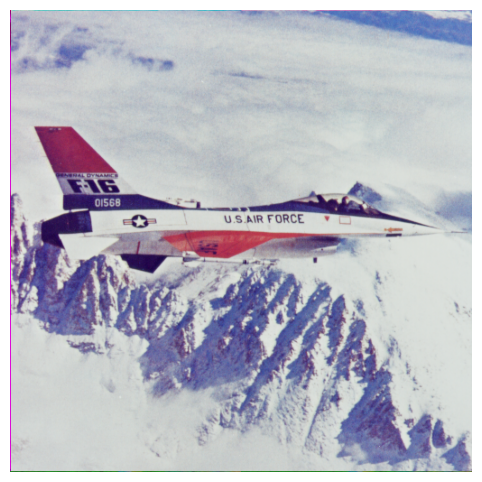

In [4]:
# read the original image
nxd = 512  # pixels in x dimension
img = cv2.imread('/kaggle/input/images/F16_GT.png')
img = cv2.resize(src=img, dsize=(nxd, nxd), interpolation=cv2.INTER_CUBIC)
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

fig1, axis1 = plt.subplots(1, 1, figsize=(10,6))
axis1.imshow(img)
axis1.set_axis_off()

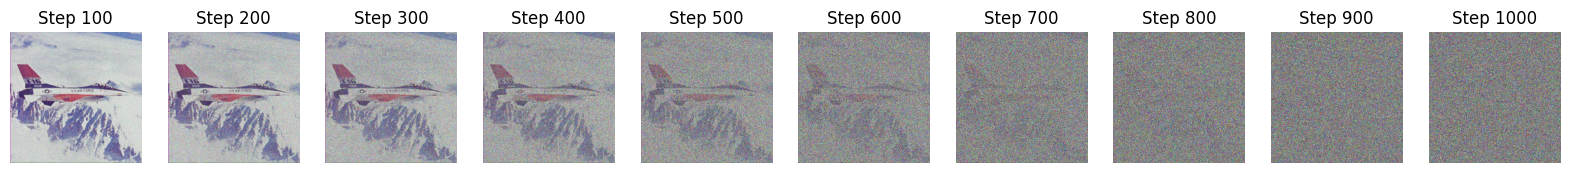

In [5]:
# define forward diffusion function for the DDPM stages
def forward_diffusion(x0, num_steps, beta_start, beta_end):
    betas = np.linspace(beta_start, beta_end, num_steps)
    alphas = 1 - betas
    alphas_cumprod = np.cumprod(alphas)
    
    x_t = []
    x_t.append(x0)
    for t in range(1, num_steps + 1):
        noise = np.random.randint(x0.min(), x0.max(), size=x0.shape)
        alpha_t = alphas_cumprod[t-1]
        x_t_prev = x_t[-1]
        x_t_current = np.sqrt(alpha_t) * x0 + np.sqrt(1 - alpha_t) * noise
        x_t.append(x_t_current)
    
    # Starting from step 100, I set it as Stage 1. Step 110 -> Stage 2, and so on
    output = np.array(x_t)[100::10]
    for i in range(len(output)):
        img_array = output[i]
        img_array = (img_array - img_array.min()) / (img_array.max() - img_array.min())  # Normalize to [0, 1]
        output[i] = img_array
    
    return output, alphas_cumprod

def plot_images(x_t, indices):
    num_images = len(indices)
    fig, axes = plt.subplots(1, num_images, figsize=(20, 12))
    for ax, idx in zip(axes, indices):
        ax.imshow(x_t[idx])
        ax.set_title(f'Step {idx*10+100}')
        ax.axis('off')
    plt.show()

# parameters for forward diffusion
x0 = img
num_steps = 1000
beta_start = 0.0001
beta_end = 0.02
x_t, alphas_cumprod = forward_diffusion(x0, num_steps, beta_start, beta_end)

# plot some stages to check the forward diffusion results
plot_images(x_t, indices=[i for i in range(0, 100, 10)])

In [16]:
# setup double convolution class
class DoubleConv(nn.Module):
    def __init__(self, input_channel, output_channel):
        super(DoubleConv, self).__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(input_channel, output_channel, kernel_size=3, padding=1),
            nn.BatchNorm2d(output_channel),
            nn.ReLU(),
            nn.Conv2d(output_channel, output_channel, kernel_size=3, padding=1),
            nn.BatchNorm2d(output_channel),
            nn.ReLU()
        )
    
    def forward(self, x):
        return self.conv(x)

# setup UNet class
class UNet(nn.Module):
    def __init__(self, input_channel, output_channel):
        super(UNet, self).__init__()
        
        # Encoder
        self.downconv1 = DoubleConv(input_channel, 64)
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2)
        
        self.downconv2 = DoubleConv(64, 128)
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2)

        self.downconv3 = DoubleConv(128, 256)
        self.pool3 = nn.MaxPool2d(kernel_size=2, stride=2)

        self.downconv4 = DoubleConv(256, 512)
        self.pool4 = nn.MaxPool2d(kernel_size=2, stride=2) 

        self.conv5 = DoubleConv(512, 1024)

        # Decoder
        self.upconv1 = nn.ConvTranspose2d(1024, 512, kernel_size=2, stride=2)
        self.conv6 = DoubleConv(1024, 512)

        self.upconv2 = nn.ConvTranspose2d(512, 256, kernel_size=2, stride=2)
        self.conv7 = DoubleConv(512, 256)

        self.upconv3 = nn.ConvTranspose2d(256, 128, kernel_size=2, stride=2)
        self.conv8 = DoubleConv(256, 128)

        self.upconv4 = nn.ConvTranspose2d(128, 64, kernel_size=2, stride=2)
        self.conv9 = DoubleConv(128, 64)

        # Output layer
        self.outconv = nn.Conv2d(64, output_channel, kernel_size=1)

    def forward(self, x):
        dc1 = self.downconv1(x)
        p1 = self.pool1(dc1)

        dc2 = self.downconv2(p1)
        p2 = self.pool2(dc2)

        dc3 = self.downconv3(p2)
        p3 = self.pool3(dc3)
        
        dc4 = self.downconv4(p3)
        p4 = self.pool4(dc4)
        
        dc5 = self.conv5(p4)
        
        uc6 = self.upconv1(dc5)
        concat6 = torch.cat([uc6, dc4], dim=1)
        c6 = self.conv6(concat6)
        
        uc7 = self.upconv2(c6)
        concat7 = torch.cat([uc7, dc3], dim=1)
        c7 = self.conv7(concat7)
        
        uc8 = self.upconv3(c7)
        concat8 = torch.cat([uc8, dc2], dim=1)
        c8 = self.conv8(concat8)
        
        uc9 = self.upconv4(c8)
        concat9 = torch.cat([uc9, dc1], dim=1)
        c9 = self.conv9(concat9)
        
        c10 = self.outconv(c9)
        #out = nn.Sigmoid()(c10)
        return c10
    
    
unet = UNet(3, 3).to(device)

Text(0.5, 1.0, 'input image 512 x 512')

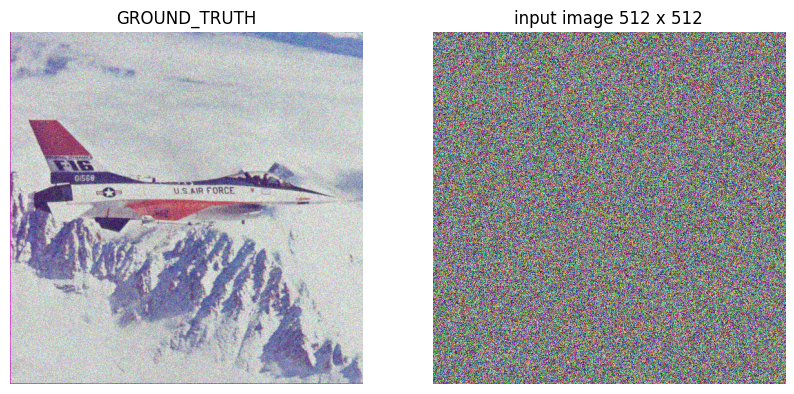

In [7]:
# input image is pure noise
input_image = torch.rand(nxd, nxd, 3).to(device)  

def torch_to_numpy(torch_array):
    return np.squeeze(torch_array.detach().cpu().numpy())
def numpy_to_torch(numpy_array):
    return torch.from_numpy(numpy_array).float()

fig2, axis2 = plt.subplots(1, 2, figsize=(10,6))
# I set step 100 image as my ground truth
axis2[0].imshow(x_t[1])
axis2[0].set_title('GROUND_TRUTH')
axis2[0].set_axis_off()
axis2[1].set_axis_off()
axis2[1].imshow(torch_to_numpy(input_image))
axis2[1].set_title('input image %d x %d' %(nxd, nxd))

In [17]:
# initialize training valiables
optimiser = torch.optim.Adam(unet.parameters(), lr=1e-4)
train_loss = []
psnr_list = []
psnr_list_at_each_stage = []
output_images = []
output_psnr = [] # records max psnr for each stage

print("Total stages:", len(x_t))

Total stages: 91


In [18]:
mse_fn = nn.MSELoss().to(device)

# training process starting from heavily corrupted images
for ind in range(len(x_t)-1, 1, -1):
    psnr_list = []
    cnt = 0
    for ep in tqdm(range(30)):
        optimiser.zero_grad()
        output_image = unet(input_image.unsqueeze(0).permute(0, 3, 1, 2))
        output_image = output_image.squeeze(0).permute(1, 2, 0)
        loss = mse_fn(numpy_to_torch(x_t[ind]).to(device), output_image)
    
        train_loss.append(loss.item())
        loss.backward() # find gradients
        optimiser.step() # does the update

        psnr = compare_psnr(torch_to_numpy(output_image), x_t[1], data_range=x_t[1].max())
        
        # early stop the stage when psnr value doesn't increase for 3 consecutive times
        if(ep > 1 and psnr.item() < psnr_list[-1]):
            cnt += 1
        psnr_list.append(psnr.item())
        if(cnt > 3):
            break
    
    print(ind)
    print(loss.item())
    output_images.append(output_image)
    psnr_list_at_each_stage.append(psnr_list)
    output_psnr.append(max(psnr_list))

100%|██████████| 30/30 [00:08<00:00,  3.64it/s]


90
0.287467360496521


100%|██████████| 30/30 [00:08<00:00,  3.63it/s]


89
0.2096148133277893


100%|██████████| 30/30 [00:08<00:00,  3.60it/s]


88
0.15416614711284637


100%|██████████| 30/30 [00:08<00:00,  3.57it/s]


87
0.11673440784215927


100%|██████████| 30/30 [00:08<00:00,  3.53it/s]


86
0.09072472155094147


100%|██████████| 30/30 [00:08<00:00,  3.52it/s]


85
0.07217209786176682


100%|██████████| 30/30 [00:08<00:00,  3.51it/s]


84
0.059669993817806244


100%|██████████| 30/30 [00:08<00:00,  3.53it/s]


83
0.0511029027402401


100%|██████████| 30/30 [00:08<00:00,  3.53it/s]


82
0.04474677890539169


 37%|███▋      | 11/30 [00:03<00:05,  3.26it/s]


81
0.06877854466438293


 40%|████      | 12/30 [00:03<00:05,  3.27it/s]


80
0.06623086333274841


 37%|███▋      | 11/30 [00:03<00:05,  3.26it/s]


79
0.06816007941961288


 40%|████      | 12/30 [00:03<00:05,  3.29it/s]


78
0.06558583676815033


 40%|████      | 12/30 [00:03<00:05,  3.29it/s]


77
0.06491420418024063


 40%|████      | 12/30 [00:03<00:05,  3.29it/s]


76
0.0646747276186943


 40%|████      | 12/30 [00:03<00:05,  3.29it/s]


75
0.06416068971157074


 40%|████      | 12/30 [00:03<00:05,  3.29it/s]


74
0.06392113864421844


 40%|████      | 12/30 [00:03<00:05,  3.28it/s]


73
0.06383290886878967


 43%|████▎     | 13/30 [00:03<00:05,  3.30it/s]


72
0.06163164973258972


 43%|████▎     | 13/30 [00:03<00:05,  3.30it/s]


71
0.06154658645391464


 40%|████      | 12/30 [00:03<00:05,  3.27it/s]


70
0.0631946548819542


 43%|████▎     | 13/30 [00:03<00:05,  3.29it/s]


69
0.06148526072502136


 43%|████▎     | 13/30 [00:03<00:05,  3.28it/s]


68
0.06150978058576584


 43%|████▎     | 13/30 [00:03<00:05,  3.27it/s]


67
0.06127803772687912


 43%|████▎     | 13/30 [00:03<00:05,  3.27it/s]


66
0.06150897592306137


 43%|████▎     | 13/30 [00:03<00:05,  3.27it/s]


65
0.061465464532375336


 43%|████▎     | 13/30 [00:03<00:05,  3.27it/s]


64
0.06129371374845505


 40%|████      | 12/30 [00:03<00:05,  3.25it/s]


63
0.06268231570720673


 43%|████▎     | 13/30 [00:03<00:05,  3.28it/s]


62
0.06144632026553154


 43%|████▎     | 13/30 [00:03<00:05,  3.28it/s]


61
0.0612466037273407


 43%|████▎     | 13/30 [00:03<00:05,  3.28it/s]


60
0.06114863604307175


 47%|████▋     | 14/30 [00:04<00:04,  3.30it/s]


59
0.06014387309551239


 40%|████      | 12/30 [00:03<00:05,  3.26it/s]


58
0.06231583282351494


 47%|████▋     | 14/30 [00:04<00:04,  3.30it/s]


57
0.05981100723147392


 43%|████▎     | 13/30 [00:03<00:05,  3.28it/s]


56
0.06049874424934387


 40%|████      | 12/30 [00:03<00:05,  3.27it/s]


55
0.06135731562972069


 43%|████▎     | 13/30 [00:03<00:05,  3.28it/s]


54
0.0597274973988533


 50%|█████     | 15/30 [00:04<00:04,  3.32it/s]


53
0.05785660073161125


 43%|████▎     | 13/30 [00:03<00:05,  3.29it/s]


52
0.05877811834216118


 40%|████      | 12/30 [00:03<00:05,  3.28it/s]


51
0.05896937847137451


 43%|████▎     | 13/30 [00:03<00:05,  3.29it/s]


50
0.05796635150909424


 43%|████▎     | 13/30 [00:03<00:05,  3.29it/s]


49
0.05711107701063156


 47%|████▋     | 14/30 [00:04<00:04,  3.30it/s]


48
0.055996280163526535


 43%|████▎     | 13/30 [00:03<00:05,  3.28it/s]


47
0.05559979006648064


 43%|████▎     | 13/30 [00:03<00:05,  3.29it/s]


46
0.05469339340925217


 47%|████▋     | 14/30 [00:04<00:04,  3.30it/s]


45
0.05350043624639511


 47%|████▋     | 14/30 [00:04<00:04,  3.30it/s]


44
0.05240991711616516


 47%|████▋     | 14/30 [00:04<00:04,  3.30it/s]


43
0.05194871872663498


 50%|█████     | 15/30 [00:04<00:04,  3.32it/s]


42
0.05031843110918999


 47%|████▋     | 14/30 [00:04<00:04,  3.30it/s]


41
0.04956434667110443


 50%|█████     | 15/30 [00:04<00:04,  3.31it/s]


40
0.0481744110584259


 47%|████▋     | 14/30 [00:04<00:04,  3.31it/s]


39
0.047500740736722946


 50%|█████     | 15/30 [00:04<00:04,  3.32it/s]


38
0.046235404908657074


 50%|█████     | 15/30 [00:04<00:04,  3.32it/s]


37
0.04513293504714966


 80%|████████  | 24/30 [00:07<00:01,  3.39it/s]


36
0.041843216866254807


 47%|████▋     | 14/30 [00:04<00:04,  3.29it/s]


35
0.04252045601606369


 50%|█████     | 15/30 [00:04<00:04,  3.31it/s]


34
0.041199713945388794


 47%|████▋     | 14/30 [00:04<00:04,  3.29it/s]


33
0.04013006389141083


 50%|█████     | 15/30 [00:04<00:04,  3.31it/s]


32
0.03900601714849472


 50%|█████     | 15/30 [00:04<00:04,  3.30it/s]


31
0.03810174763202667


 50%|█████     | 15/30 [00:04<00:04,  3.31it/s]


30
0.03695184737443924


 87%|████████▋ | 26/30 [00:07<00:01,  3.40it/s]


29
0.03410930931568146


 80%|████████  | 24/30 [00:07<00:01,  3.38it/s]


28
0.03269686549901962


 83%|████████▎ | 25/30 [00:07<00:01,  3.39it/s]


27
0.030884232372045517


 83%|████████▎ | 25/30 [00:07<00:01,  3.39it/s]


26
0.029787275940179825


 80%|████████  | 24/30 [00:07<00:01,  3.39it/s]


25
0.02819061279296875


 80%|████████  | 24/30 [00:07<00:01,  3.39it/s]


24
0.026830118149518967


 50%|█████     | 15/30 [00:04<00:04,  3.32it/s]


23
0.027506470680236816


 50%|█████     | 15/30 [00:04<00:04,  3.31it/s]


22
0.026705652475357056


 73%|███████▎  | 22/30 [00:06<00:02,  3.38it/s]


21
0.0245196670293808


 47%|████▋     | 14/30 [00:04<00:04,  3.30it/s]


20
0.02500872313976288


 47%|████▋     | 14/30 [00:04<00:04,  3.30it/s]


19
0.02392655424773693


 47%|████▋     | 14/30 [00:04<00:04,  3.30it/s]


18
0.022927165031433105


 57%|█████▋    | 17/30 [00:05<00:03,  3.34it/s]


17
0.02168276160955429


 43%|████▎     | 13/30 [00:03<00:05,  3.29it/s]


16
0.02090708166360855


 53%|█████▎    | 16/30 [00:04<00:04,  3.32it/s]


15
0.019572068005800247


 37%|███▋      | 11/30 [00:03<00:05,  3.24it/s]


14
0.01881439983844757


 50%|█████     | 15/30 [00:04<00:04,  3.32it/s]


13
0.017811186611652374


 53%|█████▎    | 16/30 [00:04<00:04,  3.33it/s]


12
0.016593866050243378


 53%|█████▎    | 16/30 [00:04<00:04,  3.33it/s]


11
0.0157253947108984


 47%|████▋     | 14/30 [00:04<00:04,  3.30it/s]


10
0.014754991047084332


 50%|█████     | 15/30 [00:04<00:04,  3.31it/s]


9
0.013756784610450268


 33%|███▎      | 10/30 [00:03<00:06,  3.22it/s]


8
0.012935846112668514


 47%|████▋     | 14/30 [00:04<00:04,  3.31it/s]


7
0.011766573414206505


 47%|████▋     | 14/30 [00:04<00:04,  3.30it/s]


6
0.011075670830905437


 30%|███       | 9/30 [00:02<00:06,  3.19it/s]


5
0.010160482488572598


 47%|████▋     | 14/30 [00:04<00:04,  3.30it/s]


4
0.009112458676099777


 57%|█████▋    | 17/30 [00:05<00:03,  3.34it/s]


3
0.008230919949710369


 43%|████▎     | 13/30 [00:03<00:05,  3.28it/s]

2
0.007420382462441921


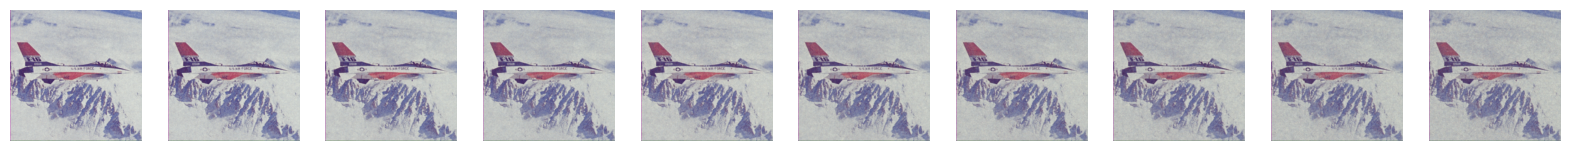

In [19]:
# plot the result images from last 10 stages
fig1, axis1 = plt.subplots(1, 10, figsize=(20,12))
for i in range(1, 11):
    axis1[i-1].set_axis_off()
    axis1[i-1].imshow(torch_to_numpy(output_images[i*-1]))

Text(0.5, 1.0, 'Output Image')

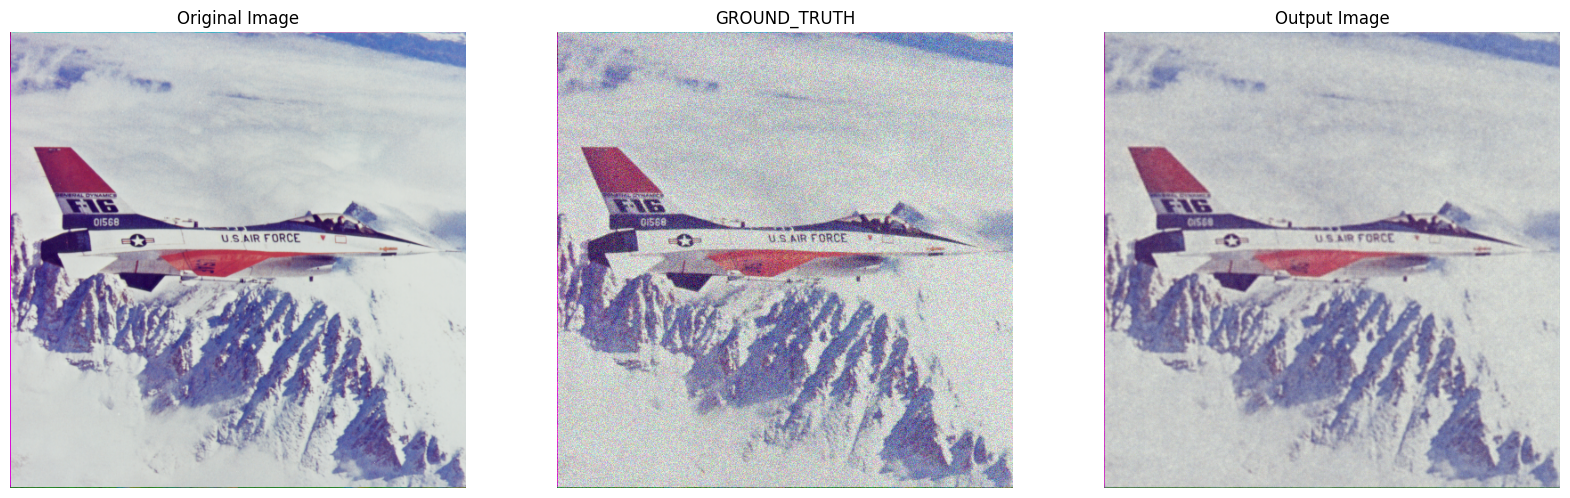

In [20]:
fig1, axis1 = plt.subplots(1, 3, figsize=(20,12))
axis1[0].imshow(img)
axis1[0].set_axis_off()
axis1[0].set_title('Original Image')
axis1[1].imshow(x_t[1])
axis1[1].set_axis_off()
axis1[1].set_title('GROUND_TRUTH')
axis1[2].imshow(torch_to_numpy(output_images[-1]))
axis1[2].set_axis_off()
axis1[2].set_title('Output Image')

Text(0, 0.5, 'MSE')

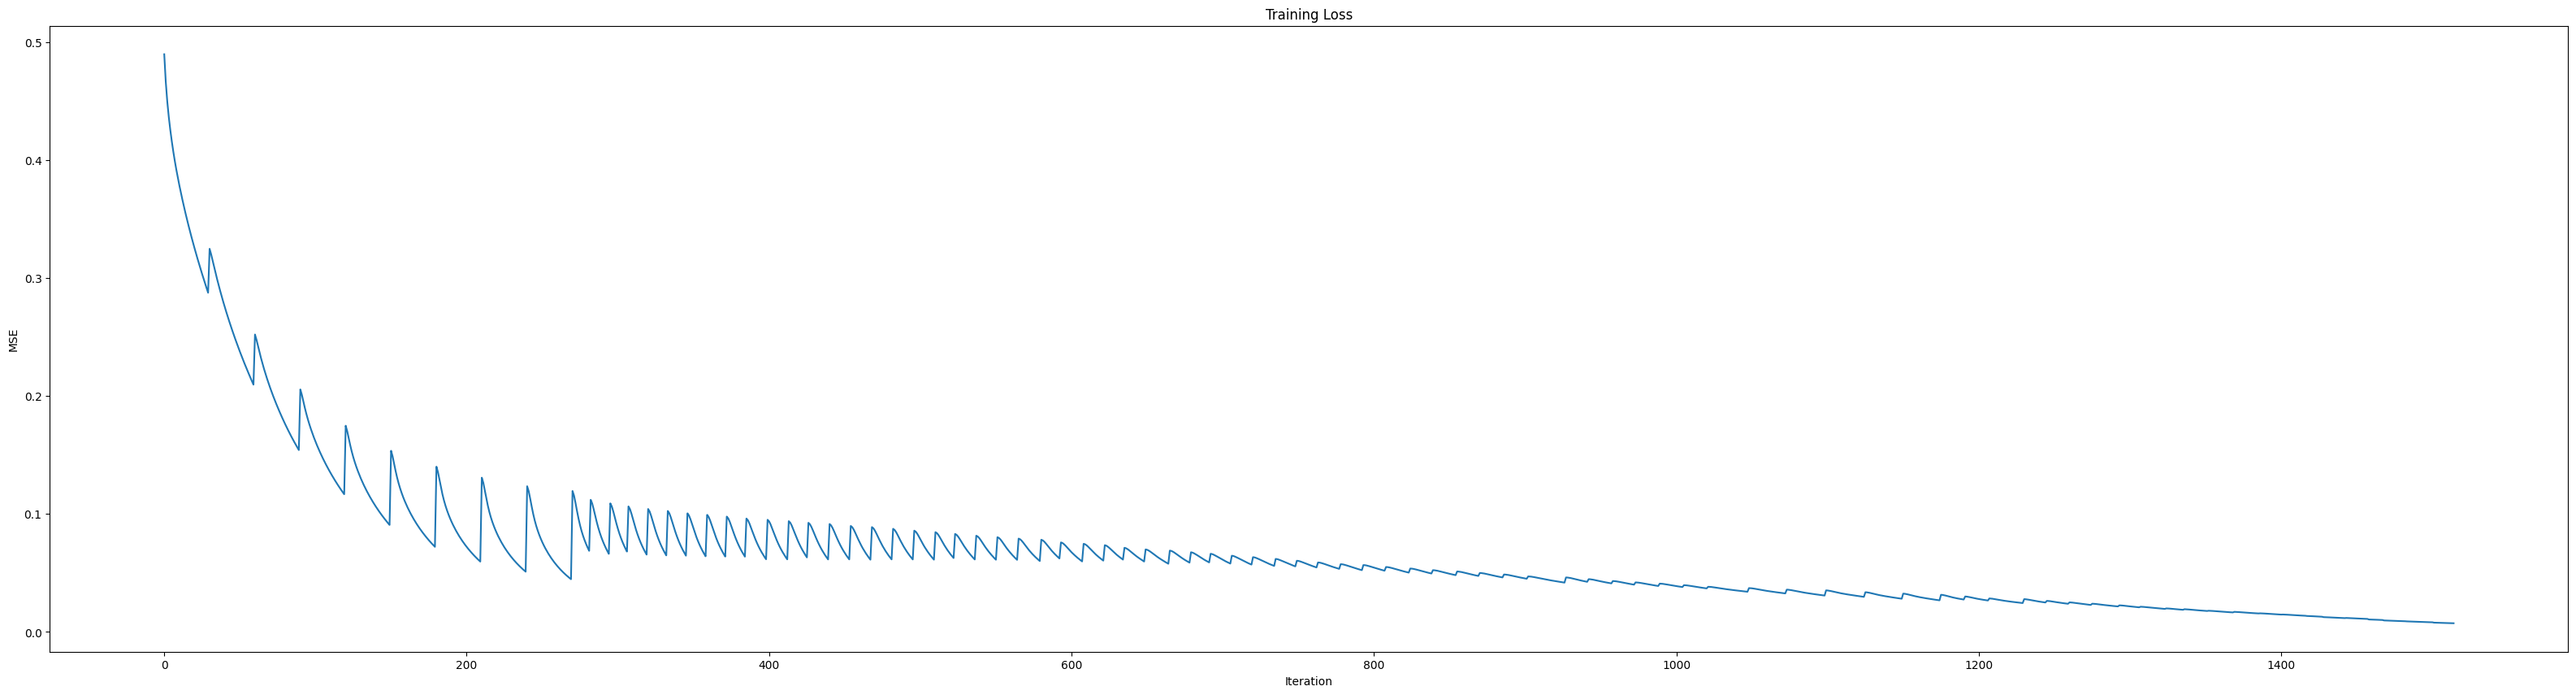

In [21]:
fig1, axis1 = plt.subplots(1, 1, figsize=(40, 10))
axis1.plot(train_loss)
axis1.set_title('Training Loss')
plt.xlabel("Iteration")
plt.ylabel("MSE")

Text(0, 0.5, 'PSNR')

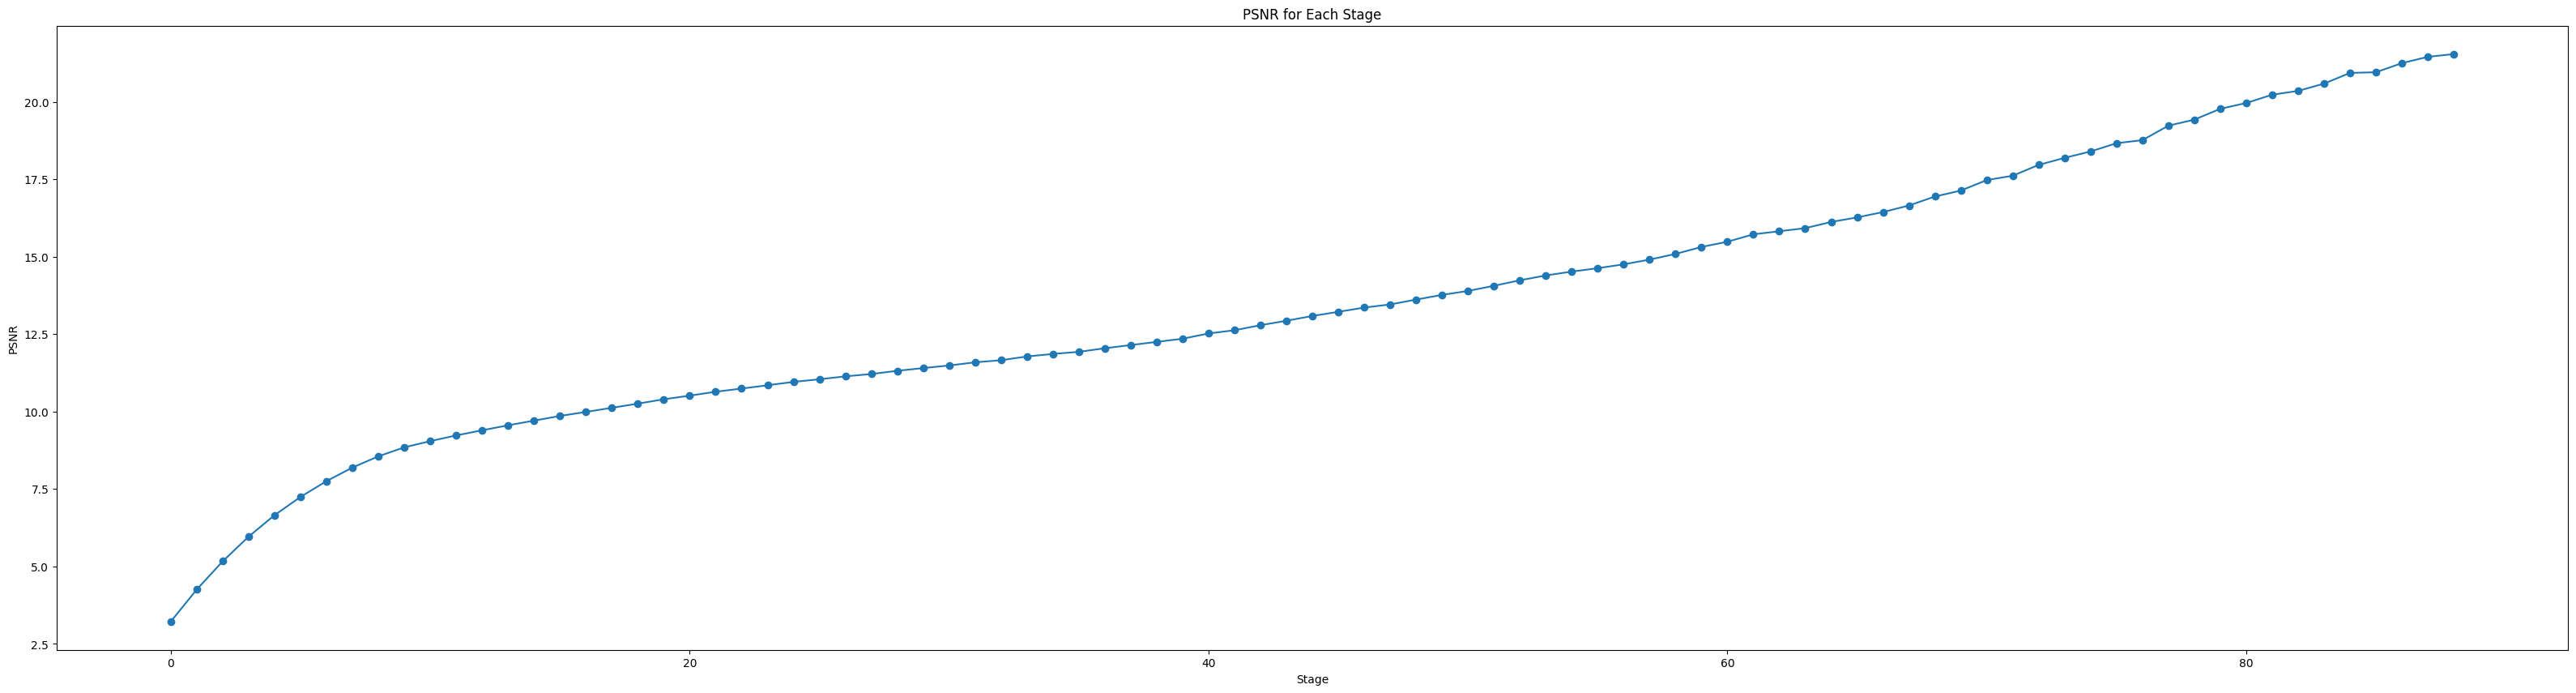

In [22]:
fig1, axis1 = plt.subplots(1, 1, figsize=(40, 10))
axis1.plot(output_psnr, marker = 'o')
axis1.set_title('PSNR for Each Stage')
plt.xlabel("Stage")
plt.ylabel("PSNR")

In [23]:
# Calculate PSNR for output image and original image
original_img = (img - img.min()) / (img.max() - img.min())
compare_psnr(torch_to_numpy(output_images[-1]), original_img, data_range=original_img.max())

20.573437224515274